In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

In [2]:
image_path = "/content/drive/MyDrive/midasmultimodalimagedatasetforaibasedskincancer"
images = []

for filename in os.listdir(image_path):
  if filename.endswith(('.jpg', '.jpeg', '.png')):
      img_path = os.path.join(image_path, filename)
      images.append(img_path)

In [3]:
df = pd.read_excel('/content/drive/MyDrive/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx')
midas_dict = dict(zip(df['midas_file_name'], df['midas_melanoma']))

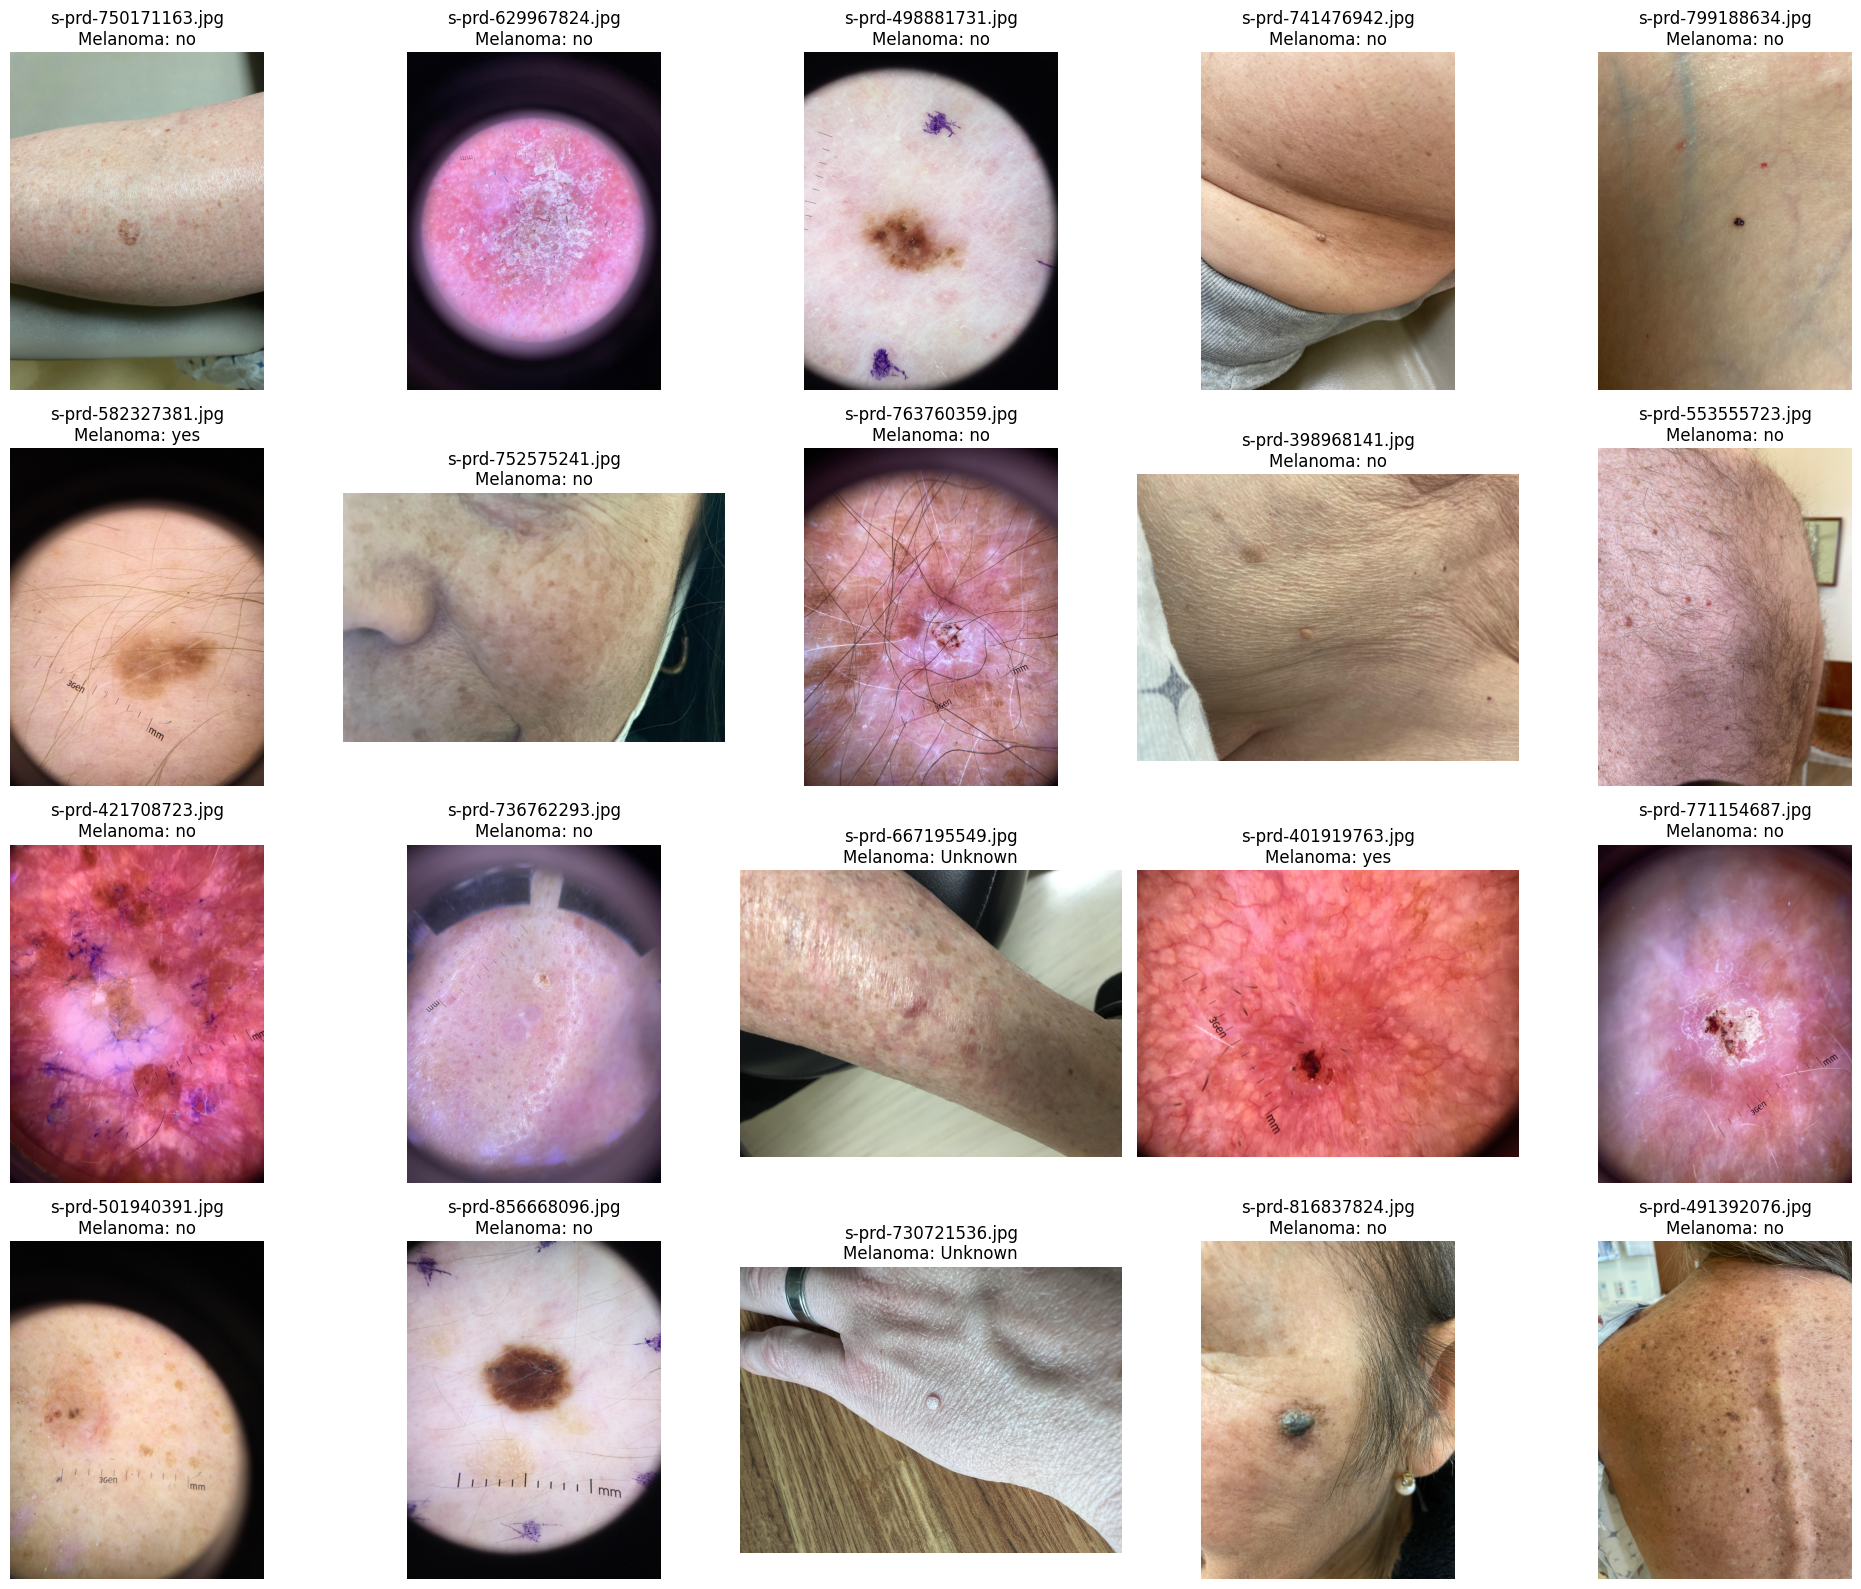

In [4]:
# Displaying the first 20 images
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for i, img_path in enumerate(images[:20]):
    try:
        filename = os.path.basename(img_path)
        melanoma_status = midas_dict.get(filename, "Unknown")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        row = i // 5
        col = i % 5
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"{filename}\nMelanoma: {melanoma_status}")
    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.tight_layout()
plt.show()

In [5]:
encoded_label_dict = {key: 1 if value == "yes" else 0 for key, value in midas_dict.items()}

In [6]:
num_melanoma = sum(value == 1 for value in encoded_label_dict.values())
num_non_melanoma = sum(value == 0 for value in encoded_label_dict.values())

print(f"Number of melanoma cases (1): {num_melanoma}")
print(f"Number of non-melanoma cases (0): {num_non_melanoma}")

Number of melanoma cases (1): 667
Number of non-melanoma cases (0): 2749


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [8]:
image_folder = "/content/drive/MyDrive/midasmultimodalimagedatasetforaibasedskincancer"
label_dict = encoded_label_dict

label_dict = {key: "yes" if value == 1 else "no" for key, value in label_dict.items()}

image_paths = [os.path.join(image_folder, image) for image in label_dict.keys()]
labels = list(label_dict.values())

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
IMG_SIZE = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',  # Binary classification: 1 or 0
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2520 validated image filenames belonging to 2 classes.
Found 632 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 212 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 52 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [10]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False

#ResNet18
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [11]:
# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=5,
#     validation_data=val_generator
# )

In [13]:
# Unfreezing the last 50 layers of the base ResNet50 model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.7492 - loss: 0.5792 - val_accuracy: 0.8133 - val_loss: 0.5003
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.8030 - loss: 0.5199 - val_accuracy: 0.8133 - val_loss: 0.4841
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.7984 - loss: 0.5182 - val_accuracy: 0.8133 - val_loss: 0.4881
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7994 - loss: 0.5130 - val_accuracy: 0.8133 - val_loss: 0.5046
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.7946 - loss: 0.5204 - val_accuracy: 0.8133 - val_loss: 0.4867
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.7863 - loss: 0.5262 - val_accuracy: 0.8133 - val_loss: 0.5083
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.7882 - loss: 0.5221 - val_accuracy: 0.8133 - val_loss: 0.4951
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.7930 - loss: 0.5197 - val_accuracy: 0.8133 - val_loss: 0.

In [14]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8338 - loss: 0.4535
Validation Loss: 0.4883247911930084
Validation Accuracy: 0.8132911324501038


In [17]:
model.save('/content/drive/MyDrive/SkinCancerModels/skin_cancer_model_v3.h5')

In [ ]:
import matplotlib.pyplot as plt

train_loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
train_acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()